In [1]:
from docplex.mp.model import Model
from docplex.mp.conflict_refiner import ConflictRefiner

import itertools as iter
from itertools import product

import time
import pandas as pd
import numpy as np

import random

from matplotlib import pyplot as plt


from mpl_toolkits.mplot3d import Axes3D

In [2]:
def f(x):
    return 1/x**4

In [3]:
def invf(x):
    return 1/x**(1/4)

In [4]:
def gradf(x):
    return -4/x**5

In [5]:
def fSH(a,x):
    return f(a) + gradf(a)*(x-a)

In [6]:
#Primera pasada

k=0

data = dict()

X = dict()
Y = dict()
D = dict()

a = 1e-6
b = 5

X[k] = a
Y[k] = 0

D[k] = 1

deltaabs = np.infty
deltarel = np.infty

epsabs = 1e-4
epsrel = 1e-1

data[k] = {"Orden de ingreso": int(k), "X" :  X[k], "Y": Y[k], "f(x)": f(X[k]), "difabs": f(a)-0, "difrel": 1, "delta": D[k]}


while k < 1e6:
    Terminar = False


    rhsA = np.array([[-gradf(X[k]),0],[0,1]])
    lhsb = np.array([f(X[k])-gradf(X[k])*X[k], 0])

    ecs, way = np.linalg.solve(rhsA,lhsb)
    

    if ecs > b:
        ecs = b
        way = max(fSH(X[k],ecs),0)
        Terminar = True
    
    deltaabs = f(ecs)-way
    deltarel = deltaabs/f(ecs)

    k+=1
    
    D[k] = 1
    X[k] = ecs
    Y[k] = way
    
    if deltaabs <= epsabs or deltarel <= epsrel:
        D[k] = 0
        Terminar = True

    data[k] = {"Orden de ingreso": int(k), "X" :  X[k], "Y": Y[k],"f(x)": f(X[k]),"difabs": deltaabs, "difrel":deltarel,"delta": D[k]}

    if Terminar:
        break

df = pd.DataFrame(data).transpose()

In [7]:
#Segunda pasada
while k < 1e4:  
    df = pd.DataFrame(data).transpose().sort_values("X").reset_index(drop=True)
    sum = df["delta"].sum()
    if sum < 1:
        break
    
    L = k
    for n in range(0,L,1):
        delta_actual = df.at[n,"delta"]
        if delta_actual == 0:
            continue
        
        X1 = df.at[n,"X"]
        X2 = df.at[n+1,"X"]

        rhsA = np.array([[-gradf(X1),1],[-gradf(X2),1]])
        lhsb = np.array([f(X1)-gradf(X1)*X1, f(X2)-gradf(X2)*X2])

        ecs, way = np.linalg.solve(rhsA,lhsb)
        way = max(way,0)

        if ecs > b:
            ecs = b

        deltaabs = f(ecs)-way
        deltarel = deltaabs/f(ecs)

        if deltaabs <= epsabs or deltarel <= epsrel:
            k2 = df.at[n,"Orden de ingreso"]

            D[k2] = 0
            data[k2]["delta"] = 0
            data[k2]["difabs"] = deltaabs
            data[k2]["difrel"] = deltarel
            continue

        k+=1
        
        D[k] = 1
        X[k] = ecs
        Y[k] = way

        data[k] = {"Orden de ingreso": int(k), "X" :  X[k], "Y": Y[k],"f(x)": f(X[k]), "difabs": deltaabs, "difrel":deltarel, "delta": D[k]}

In [8]:
print(df["delta"].sum())
print(k)

0.0
139


In [9]:
df = pd.DataFrame(data).transpose().sort_values("X").reset_index(drop=True)

In [10]:
print(df.to_markdown())

|     |   Orden de ingreso |           X |                Y |             f(x) |           difabs |    difrel |   delta |
|----:|-------------------:|------------:|-----------------:|-----------------:|-----------------:|----------:|--------:|
|   0 |                  0 | 1e-06       |      0           |      1e+24       |      1.80197e+22 | 0.0214322 |       0 |
|   1 |                 71 | 1.09769e-06 |      6.09234e+23 |      6.88777e+23 |      2.2404e+22  | 0.0411312 |       0 |
|   2 |                  1 | 1.25e-06    |      0           |      4.096e+23   |      7.38088e+21 | 0.0214322 |       0 |
|   3 |                 72 | 1.37211e-06 |      2.49542e+23 |      2.82123e+23 |      9.17668e+21 | 0.0411312 |       0 |
|   4 |                  2 | 1.5625e-06  |      0           |      1.67772e+23 |      3.02321e+21 | 0.0214322 |       0 |
|   5 |                 73 | 1.71514e-06 |      1.02212e+23 |      1.15558e+23 |      3.75877e+21 | 0.0411312 |       0 |
|   6 |                 

In [11]:
print(df.query("delta==0").to_markdown())

|     |   Orden de ingreso |           X |                Y |             f(x) |           difabs |    difrel |   delta |
|----:|-------------------:|------------:|-----------------:|-----------------:|-----------------:|----------:|--------:|
|   0 |                  0 | 1e-06       |      0           |      1e+24       |      1.80197e+22 | 0.0214322 |       0 |
|   1 |                 71 | 1.09769e-06 |      6.09234e+23 |      6.88777e+23 |      2.2404e+22  | 0.0411312 |       0 |
|   2 |                  1 | 1.25e-06    |      0           |      4.096e+23   |      7.38088e+21 | 0.0214322 |       0 |
|   3 |                 72 | 1.37211e-06 |      2.49542e+23 |      2.82123e+23 |      9.17668e+21 | 0.0411312 |       0 |
|   4 |                  2 | 1.5625e-06  |      0           |      1.67772e+23 |      3.02321e+21 | 0.0214322 |       0 |
|   5 |                 73 | 1.71514e-06 |      1.02212e+23 |      1.15558e+23 |      3.75877e+21 | 0.0411312 |       0 |
|   6 |                 

In [12]:
df = df.sort_values("Orden de ingreso").reset_index(drop=True)
print(df.to_markdown())

|     |   Orden de ingreso |           X |                Y |             f(x) |           difabs |    difrel |   delta |
|----:|-------------------:|------------:|-----------------:|-----------------:|-----------------:|----------:|--------:|
|   0 |                  0 | 1e-06       |      0           |      1e+24       |      1.80197e+22 | 0.0214322 |       0 |
|   1 |                  1 | 1.25e-06    |      0           |      4.096e+23   |      7.38088e+21 | 0.0214322 |       0 |
|   2 |                  2 | 1.5625e-06  |      0           |      1.67772e+23 |      3.02321e+21 | 0.0214322 |       0 |
|   3 |                  3 | 1.95313e-06 |      0           |      6.87195e+22 |      1.23831e+21 | 0.0214322 |       0 |
|   4 |                  4 | 2.44141e-06 |      0           |      2.81475e+22 |      5.0721e+20  | 0.0214322 |       0 |
|   5 |                  5 | 3.05176e-06 |      0           |      1.15292e+22 |      2.07753e+20 | 0.0214322 |       0 |
|   6 |                 

In [13]:
df = df.sort_values("X").reset_index(drop=True)
#print(df.to_markdown())

In [14]:
px = df["X"].values.tolist()
py = df["Y"].values.tolist()
pf = df["f(x)"].values.tolist()

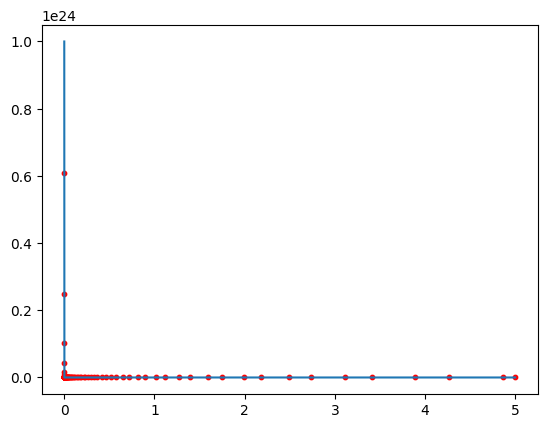

In [15]:
xs = np.linspace(a, b, 10000)
ys = f(xs)


plt.plot(xs, ys)
plt.scatter(px, py, s=10, c = "red")
plt.show()

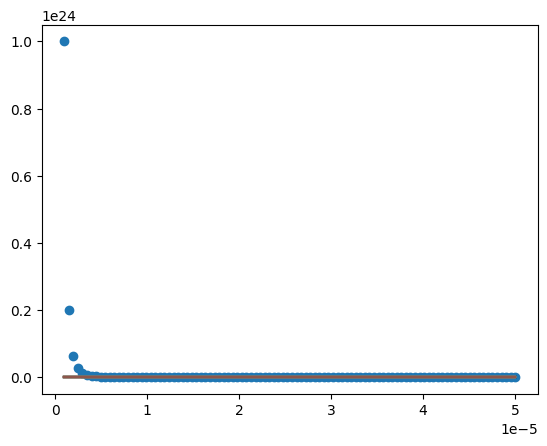

In [16]:
rel = 5e-5
for x in px:
    if x < rel:
        xs = np.linspace(a, rel, 100)
        ys = fSH(X[k],xs)
        plt.plot(xs, ys)


xs = np.linspace(a, rel, 100)
ys = f(xs)
plt.scatter(xs, ys)
#plt.scatter(X.values(), Y.values(), s=10, c = "red")
plt.show()

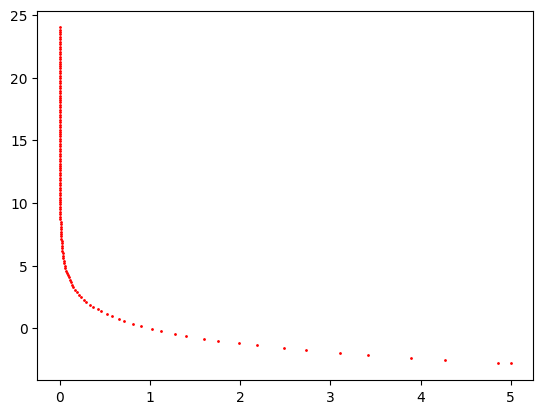

In [17]:

plt.scatter(px, np.log10(pf), s=1, c = "red")
plt.show()